<a href="https://colab.research.google.com/github/AKASSH-G/Email_Spam_or_Ham_Classification/blob/main/Email_Spam_or_Ham_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
sns.set_style('whitegrid')
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df=pd.read_csv("/content/drive/MyDrive/spam_ham_dataset.csv")
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df.columns=['Label','Text','Label_Number']
df.head()

,Label,Text,Label_Number
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
df.shape

(5171, 3)

In [8]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Label         5171 non-null   object
 1   Text          5171 non-null   object
 2   Label_Number  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [9]:
df.isnull().sum()

Label           0
Text            0
Label_Number    0
dtype: int64

In [10]:
df['Label_Number'].value_counts()

0    3672
1    1499
Name: Label_Number, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

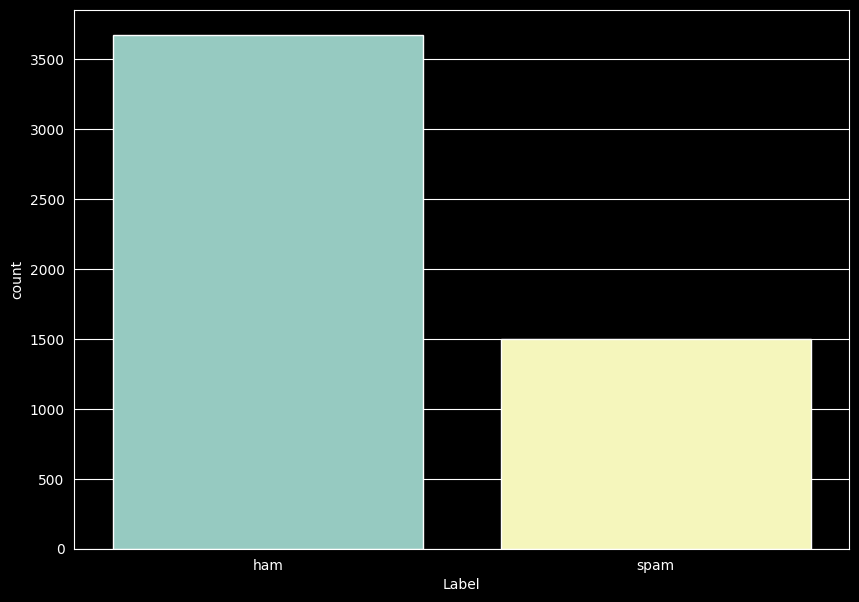

In [11]:
plt.style.use('dark_background')
plt.figure(figsize=(10,7))
sns.countplot(data=df,x="Label")

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
def count_words(text):
    words = word_tokenize(text)
    return len(words)


df['count'] = df['Text'].apply(count_words)
df['count']

0        68
1        24
2       551
3        49
4        71
       ... 
5166    156
5167    306
5168     79
5169    112
5170    200
Name: count, Length: 5171, dtype: int64

In [15]:
df.groupby("Label_Number")['count'].mean()

Label_Number
0    226.239107
1    236.387592
Name: count, dtype: float64

In [16]:
%%time 
#magic function to time the execution of the following code.
def clean_str(string, reg = RegexpTokenizer(r'[a-z]+')):  #unction to split the string into a list of words.
    # Clean a string with RegexpTokenizer
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

print('Before cleaning:')
df.head()

Before cleaning:
CPU times: user 1.4 ms, sys: 0 ns, total: 1.4 ms
Wall time: 1.41 ms


,Label,Text,Label_Number,count
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,68
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,24
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,551
3,spam,"Subject: photoshop , windows , office . cheap ...",1,49
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,71


In [17]:
print('After cleaning:')
df['Text'] = df['Text'].apply(lambda string: clean_str(string))
df.head()

After cleaning:


,Label,Text,Label_Number,count
0,ham,subject enron methanol meter this is a follow ...,0,68
1,ham,subject hpl nom for january see attached file ...,0,24
2,ham,subject neon retreat ho ho ho we re around to ...,0,551
3,spam,subject photoshop windows office cheap main tr...,1,49
4,ham,subject re indian springs this deal is to book...,0,71


In [18]:
df["Text"] = [' '.join([item for item in x.split() 
                  if item not in 'subject']) 
                  for x in df["Text"]]
df.head()

,Label,Text,Label_Number,count
0,ham,enron methanol meter this is a follow up to th...,0,68
1,ham,hpl nom for january see attached file hplnol x...,0,24
2,ham,neon retreat ho ho ho we re around to that mos...,0,551
3,spam,photoshop windows office cheap main trending a...,1,49
4,ham,re indian springs this deal is to book the tec...,0,71


In [19]:
# Import the PorterStemmer class from the nltk.stem module.
# The PorterStemmer class is used to stem words. Stemming is the process of reducing a word to its root form.
from nltk.stem import PorterStemmer

# Create a PorterStemmer object.
# The PorterStemmer object is used to stem words.
stemmer = PorterStemmer()

# Define the `stemming()` function.
# The `stemming()` function takes a string as input and returns a stemmed version of the string.
# The function first splits the string into a list of words.
# It then uses the `stemmer.stem()` method to stem each word in the list.
# Finally, it returns the list of stemmed words as a single string.
def stemming(text):
  """
  Stems the given text.

  Args:
    text: The text to stem.

  Returns:
    The stemmed text.
  """

  # Stem each word in the list.
  # Join the stemmed words together with spaces.

  # Return the stemmed text.
  return ''.join([stemmer.stem(word) for word in text])

# Apply the `stemming()` function to each row in the `df['Text']` column.
# The `apply()` function takes a function as input and applies it to each row in the DataFrame.
# In this case, the `stemming()` function is applied to each row in the `df['Text']` column.
# The result is a new column in the DataFrame called `df['StemmedText']`.
# This column contains the stemmed version of the text in each email.
df['Text'] = df['Text'].apply(stemming)

# Print the first five rows of the `df` DataFrame.
# This is done to show the data after the text has been stemmed.
df.head()


,Label,Text,Label_Number,count
0,ham,enron methanol meter this is a follow up to th...,0,68
1,ham,hpl nom for january see attached file hplnol x...,0,24
2,ham,neon retreat ho ho ho we re around to that mos...,0,551
3,spam,photoshop windows office cheap main trending a...,1,49
4,ham,re indian springs this deal is to book the tec...,0,71


In [20]:
X=df.loc[:,'Text'] # independent
y=df.loc[:,'Label_Number']

X.shape ,y.shape

((5171,), (5171,))

In [21]:
# Import the CountVectorizer class from the scikit-learn library.
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object.
cv = CountVectorizer()

# Fit the CountVectorizer object to the Text column of the df DataFrame.
# This will transform the column into a sparse matrix of token counts.
X = cv.fit_transform(df.Text)

# Assign the Label column of the df DataFrame to the y variable.
y = df.Label

In [25]:
# Split the data into a training set and a test set.
# The training set will contain 80% of the data and the test set will contain 20% of the data.
# The `random_state` argument is used to ensure that the data is split randomly each time the code is run.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a dictionary of models, where the keys are the names of the models and the values are the models themselves.
# The models are created using the `RandomForestClassifier()`, `GradientBoostingClassifier()`, `MultinomialNB()`, `LogisticRegression()`, `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LinearSVC()`, and `SVC()` classes from the scikit-learn library.
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0},
    "Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0},
    "SVM (RBF)": {"model":SVC(), "perf":0}
}

# For each model in the dictionary, train the model on the training set and measure the time it takes to train the model.
# Print the name of the model and the time it took to train the model.
for name, model in models.items():
    # Start a timer.
    start = perf_counter()

    # Fit the model on the training set.
    model['model'].fit(X_train, y_train)

    # Calculate the time it took to train the model.
    duration = perf_counter() - start

    # Round the time to two decimal places.
    duration = round(duration,2)

    # Store the time it took to train the model in the `perf` key of the model dictionary.
    model["perf"] = duration

    # Print the name of the model and the time it took to train the model.
    print(f"{name:20} trained in {duration} sec")

Random Forest        trained in 7.9 sec
Gradient Boosting    trained in 39.17 sec
MultinomialNB        trained in 0.01 sec
Logistic Regr.       trained in 1.71 sec
KNN                  trained in 0.01 sec
Decision Tree        trained in 0.88 sec
SVM (Linear)         trained in 0.2 sec
SVM (RBF)            trained in 5.29 sec


In [26]:
# Create an empty list called `models_accuracy`.
models_accuracy = []

# Iterate over the dictionary of models.
for name, model in models.items():

    # Calculate the accuracy of the model on the test set.
    accuracy = model["model"].score(X_test, y_test)

    # Append a tuple to the `models_accuracy` list.
    # The tuple contains the name of the model, the accuracy of the model on the test set, and the time it took to train the model.
    models_accuracy.append([name, accuracy, model["perf"]])

# Create an empty list called `models_accuracy1`.
models_accuracy1 = []

# Iterate over the dictionary of models.
for name, model in models.items():

    # Calculate the accuracy of the model on the training set.
    accuracy = model["model"].score(X_train, y_train)

    # Append a tuple to the `models_accuracy1` list.
    # The tuple contains the name of the model, the accuracy of the model on the training set, and the time it took to train the model.
    models_accuracy1.append([name, accuracy, model["perf"]])

In [27]:
# Create a Pandas DataFrame from the `models_accuracy` list.
df_accuracy = pd.DataFrame(models_accuracy)

# Set the column names of the DataFrame.
df_accuracy.columns = ['Model', 'Test Accuracy', 'Training time (sec)']

# Sort the DataFrame by the `Test Accuracy` column in descending order.
df_accuracy.sort_values(by = 'Test Accuracy', ascending = False, inplace=True)

# Reset the index of the DataFrame.
df_accuracy.reset_index(drop = True, inplace=True)

# Print the DataFrame.
df_accuracy

,Model,Test Accuracy,Training time (sec)
0,MultinomialNB,0.973913,0.01
1,Logistic Regr.,0.973913,1.71
2,Random Forest,0.965217,7.90
3,SVM (Linear),0.963285,0.20
4,Gradient Boosting,0.959420,39.17
5,SVM (RBF),0.956522,5.29
6,Decision Tree,0.955556,0.88
7,KNN,0.867633,0.01


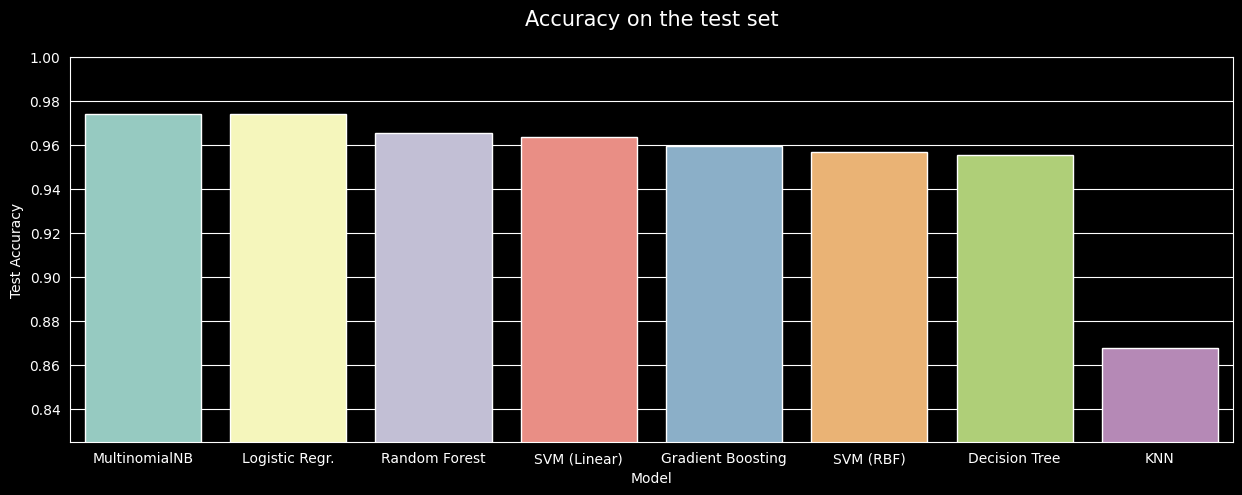

In [28]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y ='Test Accuracy', data = df_accuracy)
plt.title('Accuracy on the test set\n', fontsize = 15)
plt.ylim(0.825,1)
plt.show()

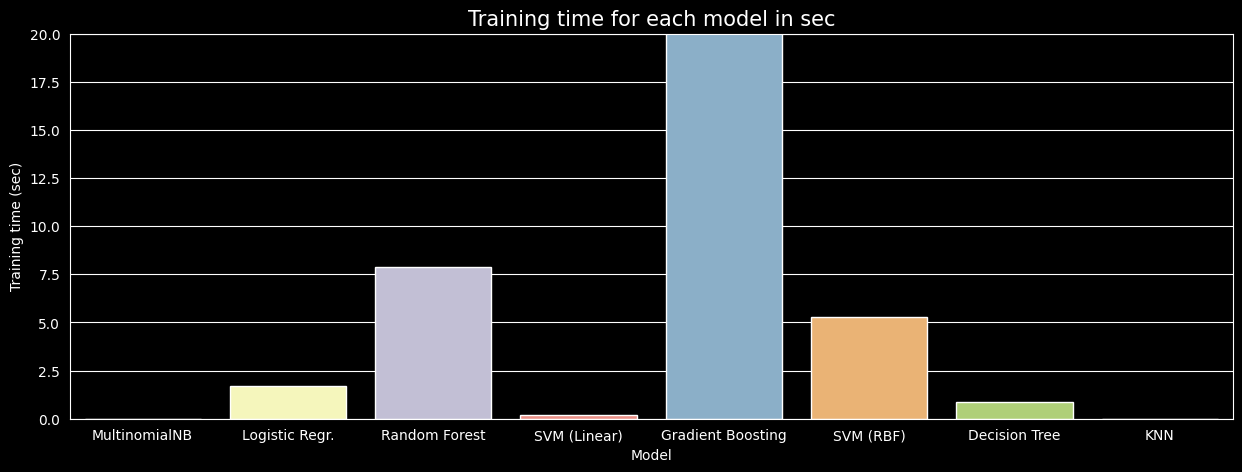

In [29]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Training time (sec)', data = df_accuracy)
plt.title('Training time for each model in sec', fontsize = 15)
plt.ylim(0,20)
plt.show()

In [30]:
# Import the MultinomialNB class from the sklearn.naive_bayes library.
from sklearn.naive_bayes import MultinomialNB

# Import the GridSearchCV class from the sklearn.model_selection library.
from sklearn.model_selection import GridSearchCV

# Create a dictionary of hyperparameters to search over.
parameters = {"alpha": [0.2, 1, 2, 5, 10], "fit_prior": [True, False]}

# Create a GridSearchCV object.
grid = GridSearchCV(MultinomialNB(), param_grid=parameters)

# Fit the GridSearchCV object to the training data.
grid.fit(X_train, y_train)

# Create a DataFrame of the GridSearchCV results.
df_results = pd.DataFrame(grid.cv_results_)

# Select the `params` and `mean_test_score` columns from the DataFrame.
df_results = df_results[['params', 'mean_test_score']]

# Sort the DataFrame by the `mean_test_score` column in descending order.
df_results.sort_values(by='mean_test_score', ascending=False, inplace=True)

# Print the DataFrame.
print(df_results)

                               params  mean_test_score
0   {'alpha': 0.2, 'fit_prior': True}         0.981625
1  {'alpha': 0.2, 'fit_prior': False}         0.981384
3    {'alpha': 1, 'fit_prior': False}         0.980899
2     {'alpha': 1, 'fit_prior': True}         0.978240
5    {'alpha': 2, 'fit_prior': False}         0.972197
4     {'alpha': 2, 'fit_prior': True}         0.967845
7    {'alpha': 5, 'fit_prior': False}         0.937141
6     {'alpha': 5, 'fit_prior': True}         0.931096
9   {'alpha': 10, 'fit_prior': False}         0.890478
8    {'alpha': 10, 'fit_prior': True}         0.881290


In [31]:

grid.best_params_

{'alpha': 0.2, 'fit_prior': True}

In [32]:
# Import the MultinomialNB class from the sklearn.naive_bayes library.
from sklearn.naive_bayes import MultinomialNB

# Get the best hyperparameters from the GridSearchCV object.
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']

# Create a MultinomialNB model with the best hyperparameters.
model = MultinomialNB(alpha=alpha)

# Fit the model to the training data.
model.fit(X_train, y_train)

# Predict the labels of the test data.
y_pred = model.predict(X_test)

# Import the classification_report and accuracy_score functions from the sklearn.metrics library.
from sklearn.metrics import classification_report, accuracy_score

# Print the classification report.
print(classification_report(y_test, y_pred))

# Print the accuracy score.
print(f'## Accuracy: {round(accuracy_score(y_test, y_pred), 3) * 100}%\n')

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       732
        spam       0.96      0.96      0.96       303

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035

## Accuracy: 97.5%



In [33]:

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       732
        spam       0.96      0.96      0.96       303

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



In [34]:
def display_result(df, number=2):
    """
    Displays the results of the spam classifier on a given number of emails.

    Args:
        df: The DataFrame containing the emails.
        number: The number of emails to display.

    Returns:
        None.
    """

    # Iterate over the first `number` emails in the DataFrame.
    for i in range(number):

        # Get the email text and label.
        msg = df['Text'].iloc[i]
        label = df["Label"].iloc[i]

        # Convert the email text to a vector.
        msg_vec = cv.transform([msg])

        # Predict the label of the email.
        pred_label = model.predict(msg_vec)

        # Print the real and predicted labels.
        print(f"**Real: {label}, Predicted: {pred_label[0]}**")

        # Print the email text.
        print(f"**E-Mail:** {msg}")

        # Print a separator between emails.
        print("_______________________________________________________________")

# Get the spam and ham emails.
df_spam = df[df['Label'] == 'spam']
df_ham = df[df['Label'] == 'ham']

# Display the results for the spam emails.
display_result(df_spam)

# Display the results for the ham emails.
display_result(df_ham)

**Real: spam, Predicted: spam**
**E-Mail:** photoshop windows office cheap main trending abasements darer prudently fortuitous undergone lighthearted charm orinoco taster railroad affluent pornographic cuvier irvin parkhouse blameworthy chlorophyll robed diagrammatic fogarty clears bayda inconveniencing managing represented smartness hashish academies shareholders unload badness danielson pure caffein spaniard chargeable levin
_______________________________________________________________
**Real: spam, Predicted: spam**
**E-Mail:** looking for medication we re the best source it is difficult to make our material condition better by the best law but it is easy enough to ruin it by bad laws excuse me you just found the best and simpliest site for medication on the net no perscription easy delivery private secure and easy better see rightly on a pound a week than squint on a million we ve got anything that you will ever want erection treatment pills anti depressant pills weight loss and 